# Frequency Modulated Signals

## Instantaneous phase and frequency

Before defining some frequency modulated signals, it's important to recall the concepts of periodicity, instantaneous phase and instantaneous frequency. Thus, a signal $x$ is said to be periodic of period $T$ if $x(t + kT) = x(t)$ for all $t$, where $k \in \mathbb{Z}$ and the fundamental period $T$ is the smallest positive real number that holds for this relation. A periodic signal $x(t)$ with a specific waveform can be expressed as:
$$
x(t) = A \xi(\phi(t)),
$$
where $A$ gives the amplitude, $\xi$ is a "canonical" function of the phase defined for a single period and $\phi(t)$ is the corresponding time-domain function for the phase.

If a complex sinusoidal waveform is defined as 
$$
x(t) = e^{j(\phi(t))},
$$
the instantaneous angular frequency $\omega(t)$, defined as the temporal rate of the instantaneous phase is:
$$
\omega(t) = \frac{\mathrm{d}\phi(t)}{\mathrm{d}t}
$$

Solving for $\phi(t)$ the following is obtained:
$$
\begin{aligned}
    \phi(t) &= \int_{-\infty}^t \omega(\tau)\mathrm{d}\tau \\
    &= \int_{-\infty}^0 \omega(\tau)\mathrm{d}\tau + \int_0^t \omega(\tau)\mathrm{d}\tau \\
    &= \phi_0 + \int_0^t \omega(\tau)\mathrm{d}\tau,
\end{aligned}
$$

where $\phi_0$ is the phase shift respect to the origin. In terms of instantaneous (ordinary) frequency, the phase can be written as: 
$$
\phi(t) = \phi_0 + 2\pi \int_0^t f(\tau)\mathrm{d}\tau.
$$
where $\tau$ is a dummy variable.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann

sns.set_style("whitegrid")

In [37]:
# Parameters
fs = 1000  # Sampling frequency
fnq = fs/2  # Nyquist frquency
ds = 1/fs  # Sampling period
dur = 1  # Duration

t = np.linspace(0, dur-ds, dur*fs)  # Time instants
N = len(t)  # Signal length

A = 1  # Amplitude
phi0 = 0  # Phase shift

In [38]:
def nextpower(num, base):
    i = 1
    while i < num: i *= base
    return i

# STFT parameters
mfft = nextpower(N, 2)  # Length of the FFT
M = 128  # Length of each segment. Factors like 32 ms, 128 ms, 256 ms, and 512 ms can be used
poverlap = 0.95  # Percentage of overlap
noverlap = int(np.ceil((M-(M % 2))*poverlap))
hop = M - noverlap  # Hop size

window = hann(M, sym=False)  # Window function

# STFT
SFT = ShortTimeFFT(
    win=window,
    hop=hop,
    fs=fs,
    fft_mode='centered',
    mfft=mfft,
)

## Constant Frequency Signal
For a sinusoidal waveform, the instantaneous frequency is constant. Thus, $f(t) = f$ and the phase is expressed as:
$$
\phi(t) = \phi_0 + 2\pi \int_0^t f \mathrm{d}\tau.
$$

Solving the integral gives:
$$
\phi(t) = \phi_0 + 2\pi f t.
$$

Thus, a sinusoidal signal can be defined as:
$$
x(t) = A e^{j(\phi_0 + 2\pi f t)}.
$$

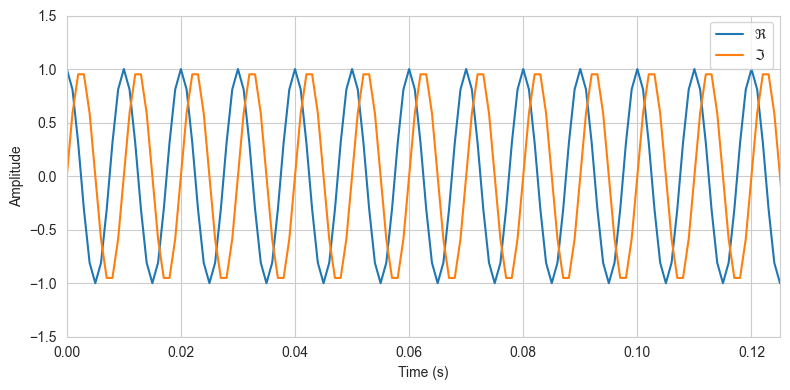

In [39]:
# Constant frequency signal
f = 100  # Frequency

phi = phi0 + 2*np.pi*f*t
x = A*np.exp(1j*(phi))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
ax.axis((0, dur/8, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend()
plt.tight_layout()
plt.show()

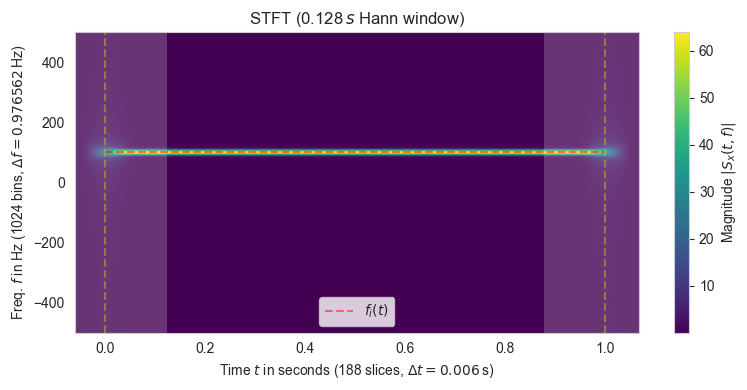

In [40]:
Sx = SFT.stft(x)

fig, ax = plt.subplots(figsize=(8, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hann window)")
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
    rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
    rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi)
)

im = ax.imshow(
    abs(Sx),
    origin='lower',
    aspect='auto',
    extent=SFT.extent(N),
    cmap='viridis'
)
ax.plot(t, f*np.ones(len(t)), 'r--', alpha=.5, label='$f_i(t)$')
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax.legend()
plt.grid(False)
fig.tight_layout()
plt.show()


## Linear Frequency Modulated Signal

In a linear-frequency modulated (LFM) signal, also called as *linear chirp*, the instantaneous frequency varies linearly with time as describes the following equation:
$$
f(t) = ct + f_0,
$$
where $f_0$ is the instantaneous frequency at time $t = 0$ and $c$ is the gradient or rate of frequency change for a given time interval, defined as:
$$
c = \frac{\Delta f}{\Delta t} = \frac{f_1 - f_0}{T},
$$
where $T$ is the period that the instantaneous frequency takes to sweep from $f_0$ to $f_1$. Then, the phase of a linear chirp is given by:
$$
\phi(t) = \phi_0 + 2\pi \int_0^t (c\tau + f_0) \mathrm{d}\tau.
$$

Solving the integral gives:
$$
\phi(t) = \phi_0 + 2\pi \left(\frac{ct^2}{2} + f_0t \right).
$$

Thus, a LFM signal is defined as:
$$
x(t) = A e^{j\left[\phi_0 + 2\pi \left(\frac{ct^2}{2} + f_0t \right)\right]}.
$$

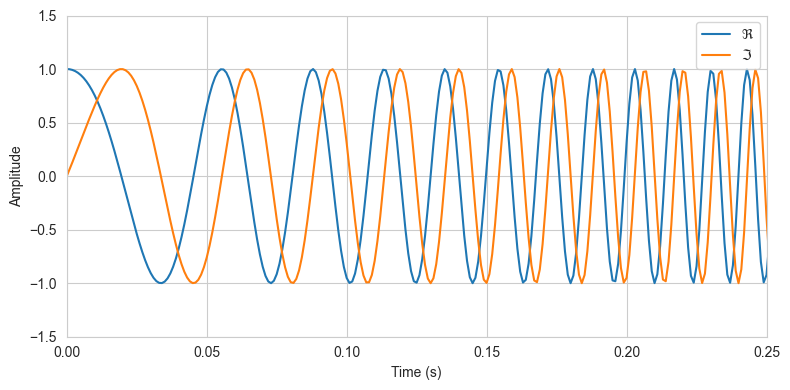

In [41]:
# LFM signal
f0 = 10  # Instantaneous initial frequency
f1 = 300  # Instantaneous final frequency

T = 1  # Sweepping period

c = (f1-f0)/T

phi = phi0 + 2*np.pi*(0.5*c*t**2 + f0*t)
x = A*np.exp(1j*(phi))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
ax.axis((0, dur/4, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

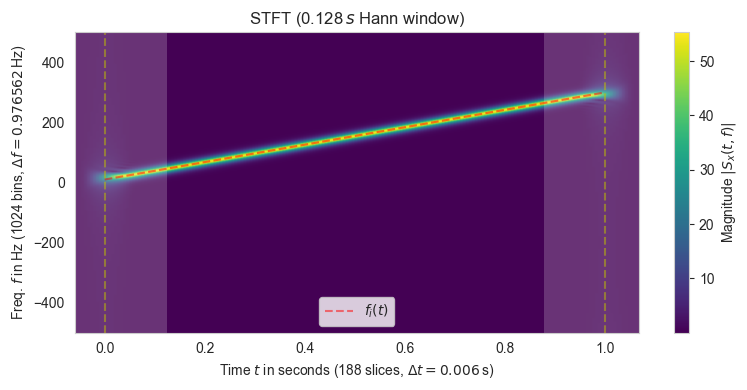

In [42]:
Sx = SFT.stft(x)

fig, ax = plt.subplots(figsize=(8, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hann window)")
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
    rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
    rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi)
)

im = ax.imshow(
    abs(Sx),
    origin='lower',
    aspect='auto',
    extent=SFT.extent(N),
    cmap='viridis'
)
ax.plot(t, c*t+f0, 'r--', alpha=.5, label='$f_i(t)$')
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax.legend()
plt.grid(False)
fig.tight_layout()
plt.show()


## Quadratic Frequency Modulated Signal

For a quadratic frequency modulated (QFM) signal, the instantaneous frequency varies quadratically with time as describes the following equation:
$$
f(t) = ct^2 + f_0,
$$
where
$$
c = \frac{f_1 - f_0}{T^2}.
$$

The corresponding time-domain function for the phase of a quadratic chirp is then:
$$
\phi(t) = \phi_0 + 2\pi \int_0^t (c\tau^2 + f_0) \mathrm{d}\tau.
$$

Solving the integral gives:
$$
\phi(t) = \phi_0 + 2\pi \left(\frac{ct^3}{3} + f_0t \right).
$$

Thus a QFM signal is defined as:
$$
x(t) = A e^{j\left[\phi_0 + 2\pi \left(\frac{ct^3}{3} + f_0t \right) \right]}.
$$

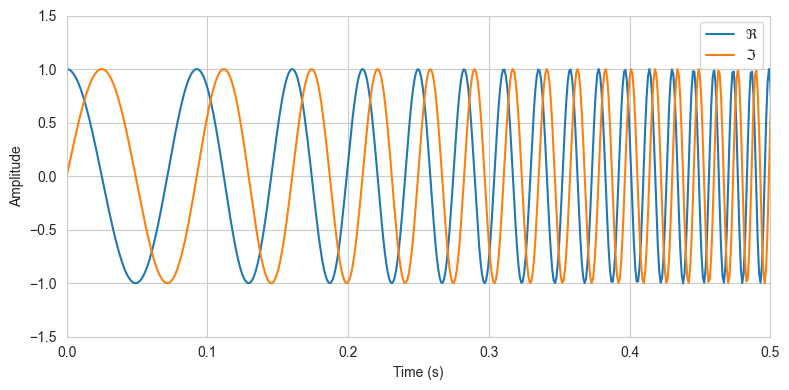

In [43]:
# QFM signal
f0 = 10  # Instantaneous initial frequency
f1 = 300  # Instantaneous final frequency
T = 1  # Sweepping period

c = (f1-f0)/T**2

phi = phi0 + 2*np.pi*((1/3)*c*t**3 + f0*t)
x = A*np.exp(1j*(phi))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
ax.axis((0, dur/2, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

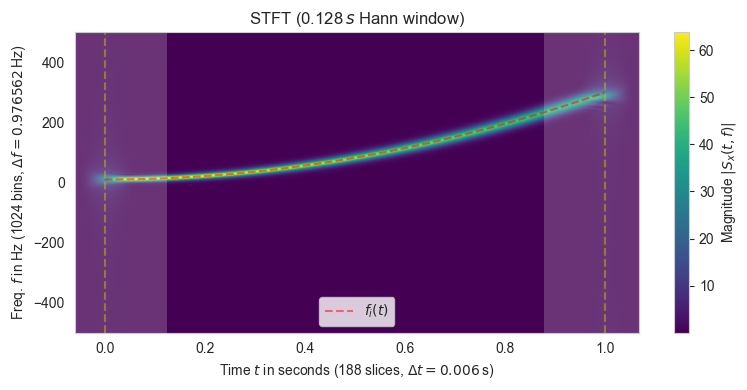

In [44]:
Sx = SFT.stft(x)

fig, ax = plt.subplots(figsize=(8, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hann window)")
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
    rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
    rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi)
)

im = ax.imshow(
    abs(Sx),
    origin='lower',
    aspect='auto',
    extent=SFT.extent(N),
    cmap='viridis'
)
ax.plot(t, c*t**2+f0, 'r--', alpha=.5, label='$f_i(t)$')
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax.legend()
plt.grid(False)
fig.tight_layout()
plt.show()


## Exponetial Frequency Modulated Signal

For an exponential frequency modulated (EFM) signal, the instantaneous frequency varies exponentially with time as described by the following equation:
$$
f(t) = f_0k^t,
$$
where $k$ is the rate of exponential change in frequency defined as:
$$
k = \left( \frac{f_1}{f_0} \right)^{\frac{1}{T}},
$$
where $T$ is the time required for the frequency to increase a factor of $f_1/f_0$. The corresponding time-domain function for the phase of an EFM is given by:
$$
\phi(t) = \phi_0 + 2\pi \int_0^t (f_0k^\tau) \mathrm{d}\tau.
$$

Solving the integral gives:
$$
\phi(t) = \phi_0 + 2\pi f_0 \left(\frac{k^t - 1}{\ln(k)} \right)
$$

Thus an EFM signal is defined as:
$$
x(t) = A e^{j\left[ \phi_0 + 2\pi f_0 \left(\frac{k^t - 1}{\ln(k)} \right) \right]}.
$$

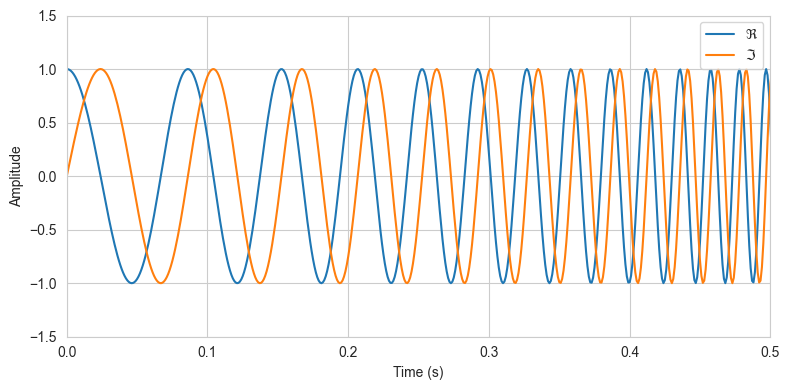

In [45]:
# EFM signal
f0 = 10  # Instantaneous initial frequency
f1 = 300  # Instantaneous final frequency
T = 1  # Sweepping period

k = (f1/f0)**(1/T)

phi = phi0 + 2*np.pi*f0*((k**t-1)/np.log(k))
x = A*np.exp(1j*(phi))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
ax.axis((0, dur/2, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

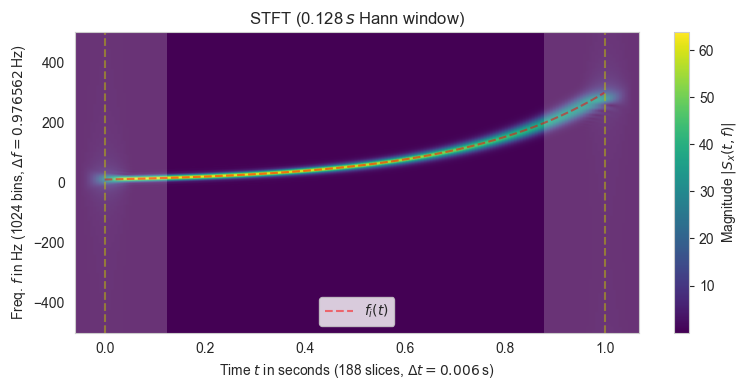

In [46]:
Sx = SFT.stft(x)

fig, ax = plt.subplots(figsize=(8, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hann window)")
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
    rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
    rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi)
)

im = ax.imshow(
    abs(Sx),
    origin='lower',
    aspect='auto',
    extent=SFT.extent(N),
    cmap='viridis'
)
ax.plot(t, f0*k**t, 'r--', alpha=.5, label='$f_i(t)$')
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax.legend()
plt.grid(False)
fig.tight_layout()
plt.show()


## Sinusoidal Frequency Modulated Signal

For a sinusoidal frequency modulated (SFM) signal $x_c(t)$, the instantaneous frequency $f(t)$ varies periodically with time as describes the following equation:
$$
f(t) = f_c + x_m(t),
$$
where $f_c$ is the carrier's base frequency defined as:
$$
f_c = f_0 + A_m,
$$
and $x_m(t)$ is the modulator sinusoid given by
$$
x_m(t) = A_m \cos(2\pi f_m t),
$$
where $f_m$ is the frequency of the modulation and $A_m$ is the amplitude of the modulation defined as:
$$
A_m = \frac{f_1 - f_0}{2}.
$$

The corresponding time-domain function for the phase of the SFM is:
$$
\phi(t) = \phi_0 + 2\pi \int_0^t (f_c + x_m(\tau)) \mathrm{d}\tau.
$$

Solving the integral gives:
$$
\int_0^t (x_m(\tau)) \mathrm{d}\tau = A_m \frac{\sin(2\pi f_m t)}{2\pi f_m}.
$$

Then, the phase is expressed as:
$$
\phi(t) = \phi_0 + 2\pi f_c t + \frac{A_m}{f_m} \sin(2\pi f_m t).
$$

Thus the SFM signal is defined as:
$$
x(t) = A e^{j\left[ \phi_0 + 2\pi f_c t + \frac{A_m}{f_m} \sin(2\pi f_m t) \right]}.
$$

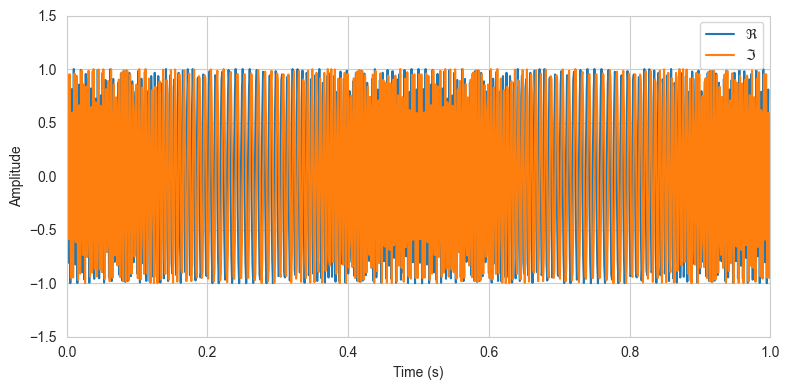

In [59]:
# SFM signal
Ac = 1  # Amplitude
f0 = 100  # Instantaneous initial frequency
f1 = 300  # Instantaneous final frequency
Am = (f1 - f0)/2  # Frequency deviation
fc = f0 + Am  # Carrier frequency
fm = 2  # Modulation frequency

phi = phi0 + 2*np.pi*fc*t + (Am/fm)*np.sin(2*np.pi*fm*t)
x = Ac*np.exp(1j*(phi))

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, np.real(x), label=r'$\Re$')
ax.plot(t, np.imag(x), label=r'$\Im$')
ax.axis((0, dur, -1.5, 1.5))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

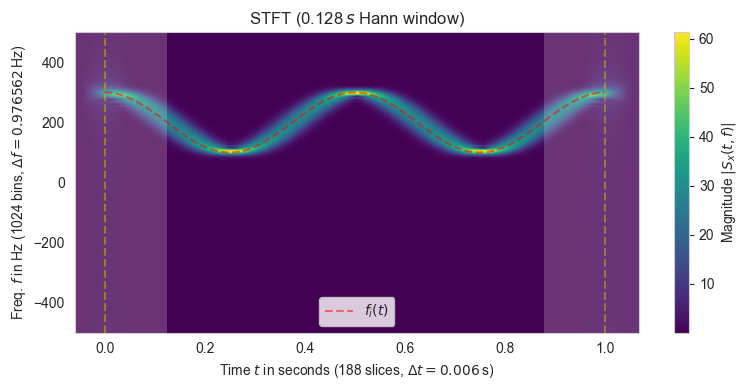

In [56]:
Sx = SFT.stft(x)

fig, ax = plt.subplots(figsize=(8, 4))
t_lo, t_hi = SFT.extent(N)[:2]  # time range of plot
ax.set_title(rf"STFT ({SFT.m_num*SFT.T:g}$\,s$ Hann window)")
ax.set(
    xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
    rf"$\Delta t = {SFT.delta_t:g}\,$s)",
    ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
    rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
    xlim=(t_lo, t_hi)
)

im = ax.imshow(
    abs(Sx),
    origin='lower',
    aspect='auto',
    extent=SFT.extent(N),
    cmap='viridis'
)
ax.plot(t, fc + Am*np.cos(2*np.pi*fm*t), 'r--', alpha=.5, label='$f_i(t)$')
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")

# Shade areas where window slices stick out to the side:
for t0_, t1_ in [(t_lo, SFT.lower_border_end[0] * SFT.T), (SFT.upper_border_begin(N)[0] * SFT.T, t_hi)]:
    ax.axvspan(t0_, t1_, color='w', linewidth=0, alpha=.2)
for t_ in [0, N * SFT.T]:  # mark signal borders with vertical line:
    ax.axvline(t_, color='y', linestyle='--', alpha=0.5)

ax.legend()
plt.grid(False)
fig.tight_layout()
plt.show()
